In [4]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
image_path = "./Image"
mask_path = "./Mask"
image_path_list = sorted(os.listdir(image_path))
mask_path_list = sorted(os.listdir(mask_path))
image_path_list = [os.path.join(image_path, i) for i in image_path_list]
mask_path_list = [os.path.join(mask_path, i) for i in mask_path_list]

In [6]:
# load mask and mask
images = [cv2.imread(i) for i in image_path_list]
masks = [cv2.imread(i, cv2.IMREAD_GRAYSCALE) for i in mask_path_list]

In [18]:
# get orientation of the image using mask
def get_orientation(mask):
    def max_ones_in_line(line):
        max_count = 0
        current_count = 0
        for value in line:
            if value == 1:
                current_count += 1
                max_count = max(max_count, current_count)
            else:
                current_count = 0
        return max_count

    # Convert mask to numpy array if it's not already
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)
    
    mask[mask == 255] = 1

    max_row_ones = max(max_ones_in_line(row) for row in mask)
    max_col_ones = max(max_ones_in_line(col) for col in mask.T)  # Transpose to iterate over columns

    return "Horizontal" if max_row_ones > max_col_ones else "Vertical"

In [8]:
print(get_orientation(masks[1]))

Horizontal


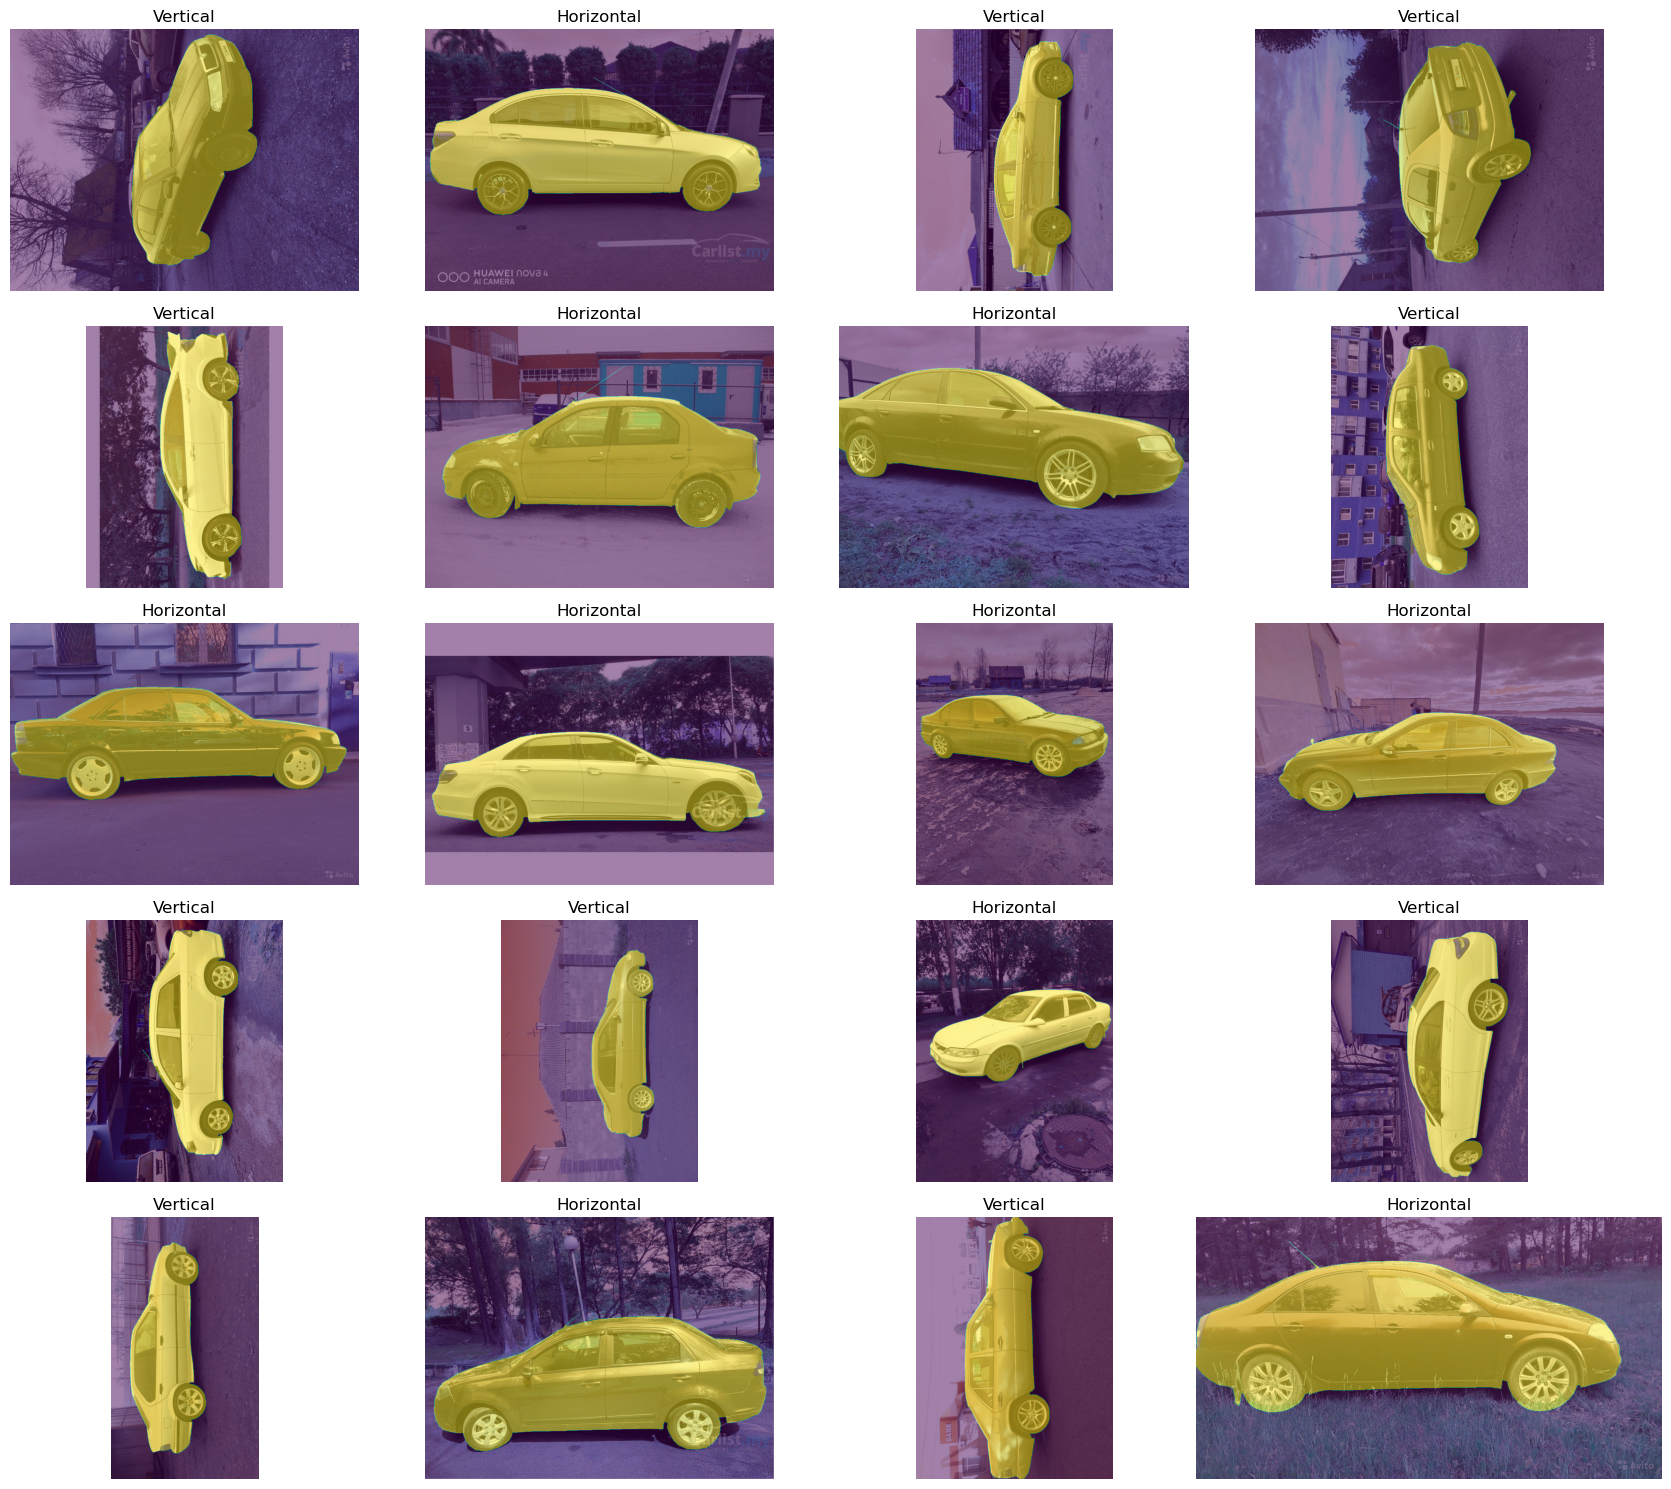

In [9]:
fig, axs = plt.subplots(5,4, figsize = (18,15))
k = 0
for i in range(5):
    for j in range(4):
        axs[i, j].axis('off')
        axs[i,j].imshow(images[k])
        axs[i,j].imshow(masks[k], alpha=.5)
        axs[i,j].set_title(get_orientation(masks[k]))
        k+=1
        plt.tight_layout()

plt.show()

In [12]:
# get ground mask using kmeans clustering
def get_ground_mask(img, k=3):
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Reshape the image into a 2D array of pixels
    pixel_values = hsv_image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Define criteria, number of clusters(K), and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    K = 3  # Number of clusters, adjust as necessary
    _, labels, (centers) = cv2.kmeans(pixel_values, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to 8 bit values
    centers = np.uint8(centers)
    labels = labels.flatten()

    # Convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]

    # Reshape back to the original image dimension
    segmented_image = segmented_image.reshape(hsv_image.shape)

    # Convert the image back to BGR to display
    segmented_image_bgr = cv2.cvtColor(segmented_image, cv2.COLOR_HSV2BGR)

    # Identify the cluster with the maximum distribution at the bottom
    # Initialize an array to store the sum of pixels for each cluster
    cluster_distribution = np.zeros(K)

    # Calculate the distribution of clusters along the y-axis
    height, width = hsv_image.shape[:2]
    for i in range(K):
        cluster_mask = (labels == i).reshape(height, width)  # Mask for the current cluster
        cluster_distribution[i] = np.sum(cluster_mask[-height//4:])  # Sum pixels in the bottom quarter of the image

    # Identify the cluster with the maximum distribution at the bottom
    ground_cluster = np.argmax(cluster_distribution)

    ground_mask = (labels == ground_cluster).reshape(height, width).astype(np.uint8)

    # Optionally, dilate the mask to cover minor gaps or noise
    kernel = np.ones((5, 5), np.uint8)
    ground_mask = cv2.dilate(ground_mask, kernel, iterations=2)

    return ground_mask

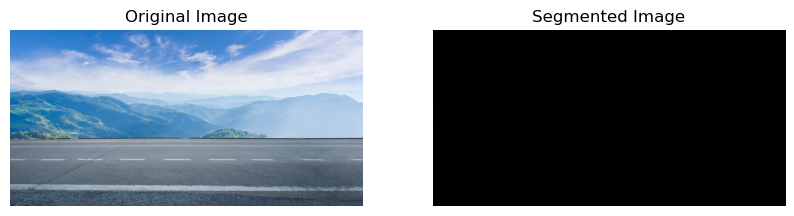

In [13]:
# Display the segmented image
original_image = cv2.imread('background.jpg')
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
segmented_image_bgr = get_ground_mask(original_image)
segmented_image_rgb = cv2.cvtColor(segmented_image_bgr, cv2.COLOR_BGR2RGB)

# Plot the images
plt.figure(figsize=(10, 5))

# Plot Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

# Plot Segmented Image
plt.subplot(1, 2, 2)
plt.imshow(segmented_image_rgb)
plt.title('Segmented Image')
plt.axis('off')

# Show the plots
plt.show()


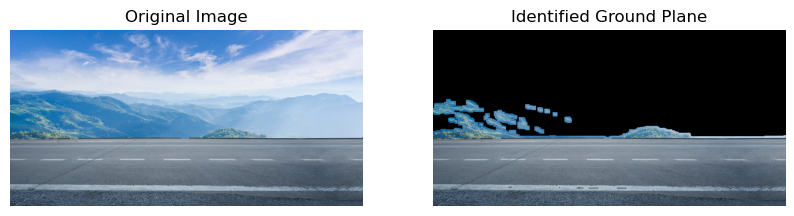

In [15]:
# Color the ground plane in the original image
background = cv2.imread('background.jpg')
ground_mask = get_ground_mask(background)
img = cv2.imread('background.jpg')
ground_plane = cv2.bitwise_and(img, img, mask=ground_mask)

plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Ground Plane
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ground_plane, cv2.COLOR_BGR2RGB))
plt.title('Identified Ground Plane')
plt.axis('off')

plt.show()


In [16]:
car_contours, _ = cv2.findContours(masks[1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the bounding box for the car
x, y, w, h = cv2.boundingRect(car_contours[0])
# Find the y-coordinate of the lowest non-zero pixel in the ground mask
background = cv2.imread("./background.jpg")
background = cv2.resize(background, images[1].shape[:2][::-1], interpolation=cv2.INTER_CUBIC)
ground_mask = get_ground_mask(background)
ground_y = np.max(np.where(ground_mask > 0)[0])
ground_y = ground_y - 20
# Calculate the new y-coordinate for the car
new_y = ground_y - h

# The car's x-coordinate remains the same (or can be centered)
new_x = x
new_x = (ground_mask.shape[1] - w) // 2
# Create a translation matrix
translation_matrix = np.float32([[1, 0, new_x - x], [0, 1, new_y - y]])

# Translate the car mask
translated_car_mask = cv2.warpAffine(masks[1], translation_matrix, (masks[1].shape[1], masks[1].shape[0]))

# Translate the car image (assuming car_image is the original image of the car)
translated_car_image = cv2.warpAffine(images[1], translation_matrix, (images[1].shape[1], images[1].shape[0]))

translated_car_image[translated_car_mask==0] = 0
background[translated_car_mask==1] = 0
result_image = cv2.add(background, translated_car_image)

In [19]:
def blend_car_with_background(car_image, car_mask, background_image):
    # Find contours of the car mask
    if get_orientation(car_mask) == "Vertical":
        car_mask = cv2.rotate(car_mask, cv2.ROTATE_90_CLOCKWISE)
        car_image = cv2.rotate(car_image, cv2.ROTATE_90_CLOCKWISE)
    
    car_contours, _ = cv2.findContours(car_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding box for the car
    x, y, w, h = cv2.boundingRect(car_contours[0])

    # Resize the background image to match the car image dimensions
    background = cv2.resize(background_image, car_image.shape[:2][::-1], interpolation=cv2.INTER_CUBIC)

    # Get the ground mask and find the y-coordinate of the lowest non-zero pixel
    ground_mask = get_ground_mask(background)
    ground_y = np.max(np.where(ground_mask > 0)[0]) - 20

    # Calculate the new y-coordinate for the car
    new_y = ground_y - h

    # Center the car horizontally
    new_x = (ground_mask.shape[1] - w) // 2

    # Create a translation matrix
    translation_matrix = np.float32([[1, 0, new_x - x], [0, 1, new_y - y]])

    # Translate the car mask
    translated_car_mask = cv2.warpAffine(car_mask, translation_matrix, (car_mask.shape[1], car_mask.shape[0]))

    # Translate the car image
    translated_car_image = cv2.warpAffine(car_image, translation_matrix, (car_image.shape[1], car_image.shape[0]))

    # Apply the mask to the car image and background
    translated_car_image[translated_car_mask == 0] = 0
    background[translated_car_mask == 1] = 0

    # Blend the images
    result_image = cv2.add(background, translated_car_image)

    return result_image


In [24]:
background = cv2.imread('background.jpg')
result_image = blend_car_with_background(images[2], masks[2], background)

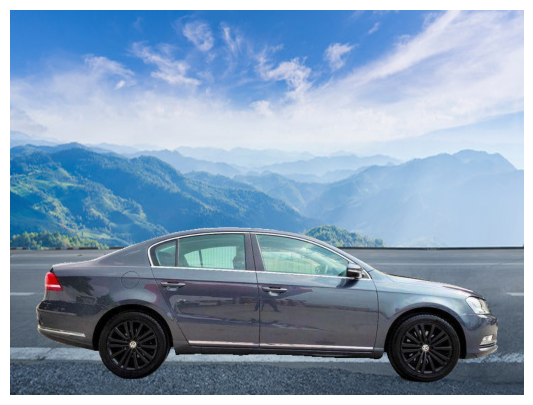

In [25]:
# plot the result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [29]:
background = cv2.imread('background2.jpeg')
result_image = blend_car_with_background(images[1], masks[1], background)

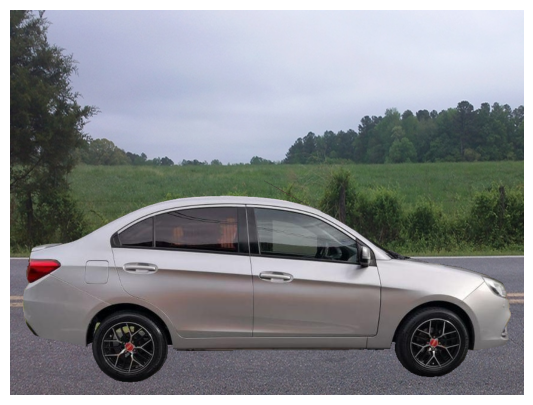

In [30]:
# plot the result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()